## LSTM Prediction:
- [In Progress:] model tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pickle


from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

import time
import warnings

import tensorflow as tf
from keras.layers import Dense, LSTM
from keras import Sequential

In [2]:
# define data paths:
feature_path = 'data/Germany/input_data.csv'
target_path = 'data/Germany/heads.csv'

### Functions for data preprocessing and feature engineering:

In [3]:
def read_data(target_path, feature_path):
    
    '''
    Function: reads in target and feature data into dataframes
    
    Arguments:
        * target_path: path to target data
        * feature path: path to feature data
    
    Return: 
        * df: dataframe combining feature and target data
    
    '''
    
    # read feature data
    df_X = pd.read_csv(feature_path)
    df_X = df_X.set_index('time')
    df_X.index = pd.to_datetime(df_X.index)

    # filter feature data for data within training period
    df_X = df_X[(df_X.index>='2002-05-01' )& (df_X.index<='2016-12-31')]

    # read target data
    df_y = pd.read_csv(target_path)
    df_y = df_y.set_index('Date')
    df_y.index = pd.to_datetime(df_y.index)
    df_y.index = df_y.index.rename('time')
    df_y = df_y[(df_y.index>=df_X.index[0])]

    df = pd.concat([df_X, df_y], axis=1)
    
    return df


### Feature Engineering:
class engineer_features():
    '''
    Class to perform various types of feature engineering, new functions to be added
    '''
    def __init__(self, df):
        self.df = df
    
    def year_signal(self):
        timestamp_s = self.df.index.map(pd.Timestamp.timestamp)
        day = 24*60*60
        year = (365.2425)*day

        self.df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        self.df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
        
        # visualize year signal:
        plt.plot(np.array(df['Year sin'])[:300])
        plt.plot(np.array(df['Year cos'])[:300])
        plt.xlabel('Time [h]')
        plt.title('Year signal')
        plt.show()
        
    def lag_features(self, features):
        # create lag feature
        for j in features:
            temps = pd.DataFrame(self.df[j].values)
            shifted = temps.shift(1)
            for k in lags:
                window, means = {}, {}
                window["{}".format(k)] = shifted.rolling(window=k)
                means["{}".format(k)] = window["{}".format(k)].mean()
                self.df["{}_avg_{}".format(j,k)]=means["{}".format(k)].to_numpy()


        # drop missing values after creating lag features
        self.df.dropna(inplace = True)
    
def split(df, val_year, test_year):
    '''
    helper function to split dataset into train-val-test sets
    '''
    
    train_df = df[df.index < val_year]
    val_df = df[(df.index >= val_year) & (df.index < test_year)]
    test_df = df[(df.index >= test_year)]
    
    return train_df, val_df, test_df

class Standardize():
    def __init__(self, train_df, val_df, test_df, target_col):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.train_mean = self.train_df.mean()
        self.train_std = self.train_df.std()
        self.target_col = target_col
    
    def scale(self):
        self.train_df = (self.train_df - self.train_mean) / self.train_std
        self.val_df = (self.val_df - self.train_mean) / self.train_std
        self.test_df = (self.test_df - self.train_mean) / self.train_std
        
        return self.train_df, self.val_df, self.test_df
        
        
    def reverse_scale_target(self, data):
        reversed_data = data * self.train_std[self.target_col] + self.train_mean[self.target_col]
        
        return reversed_data
        
    
def split_X_y(train_df, val_df, test_df):
    
    train_X_df = train_df.drop(columns = ['head'])
    train_y_df = train_df['head']

    val_X_df = val_df.drop(columns = ['head'])
    val_y_df = val_df['head']

    test_X_df = test_df.drop(columns = ['head'])
    test_y_df = test_df['head']
    
    return train_X_df, train_y_df, val_X_df, val_y_df, test_X_df, test_y_df

# reshape data for training and testing:
def reshape_data(window_length, X, y, return_label_sequence = False):
    '''
    helper function to reshape data for lstm model
    
    Arguments:
        * window_length: int
            + number of time steps in each input sequence for lstm
        * X: pd.DataFrame
            + feature dataframe
        * y: pd.DataFrame
            + target dataframe
        * return_label_sequence: bool
            + if True, will perform rolling window on y for an LSTM model that predicts a sequence
            + if False, will return y as a 1d tensor for an LSTM model that only predicts the final output
    
    Return:
        * reshaped X
        * reshaped y
    
    '''

    # Define a list to hold the resulting tensors
    X_tensors = []
    y_tensors = []
    
    # Reshape X
    for window in X.rolling(window=window_length):
        # Extract the data from the window
        window_data = window.values

        # Check if the window has enough data points
        if len(window_data) == window_length:
            X_tensors.append(window_data)
            
    X_final_tensor = np.stack(X_tensors)
    X_final_tensor = X_final_tensor.reshape(-1, window_length, X.shape[1])
    
    # Reshape y
    
    # if we want to return a sequence in LSTM, perform windowing on y
    if return_label_sequence:
        for window in y.rolling(window=window_length):
            # Extract the data from the window
            window_data = window.values

            # Check if the window has enough data points
            if len(window_data) == window_length:
                y_tensors.append(window_data)
        y_final_tensor = np.stack(y_tensors)
    # if we don't want to return a sequence in LSTM, return y as a 1d array
    else:
        y_final_tensor = y[window_length-1:]

    return tf.constant(X_final_tensor), tf.constant(y_final_tensor)


# perform the entire splitting and preprocessing pipeline:
def preprocessing_pipeline(df, 
                           val_year,
                           test_year, 
                           window_length, 
                           scaling,
                           target_col,
                           return_sequence = None
                          ):
    '''
    Function: performs splitting, scaling, reshaping and other preprocessing steps on data
    
    Arguments:
        * df: pd.DataFrame
            + dataframe containing target and feature data
        * val_year: string
            + split year between training and validation periods
        * test_year: string
            + split year between validation and testing periods
        * window_length: int
            + number of time steps in each input sequence for lstm
        * scaling: object
            + method of scaling data
        * target_col: string
            + name of target variable
        * return_label_sequence: bool
            + if True, will perform rolling window on y for an LSTM model that predicts a sequence
            + if False, will return y as a 1d tensor for an LSTM model that only predicts the final output
    Returns:
        train_X, train_y, val_X, val_y, test_X, test_y
    '''
    
    # perform splitting and standardizing
    train_df, val_df, test_df = split(df, val_year, test_year)
    
    scale_method = scaling(train_df, val_df, test_df, target_col)
    train_df, val_df, test_df = scale_method.scale()
    
    (train_X, train_y, val_X, val_y, test_X, test_y) = split_X_y(train_df, val_df, test_df)
    
    # reshape data
    train_X, train_y = reshape_data(window_length, train_X, train_y, return_sequence)
    val_X, val_y = reshape_data(window_length, val_X, val_y, return_sequence)
    test_X, test_y = reshape_data(window_length, test_X, test_y, return_sequence)
    
    
    return train_X, train_y, val_X, val_y, test_X, test_y, scale_method
    


In [36]:
# Build LSTM model:
def get_model(lstm_size, output_size = 1):     

    # design network
    model = Sequential()
    model.add(LSTM(lstm_size))
    model.add(Dense(output_size))

    
    # train model
    model.compile(loss='mse', 
                  optimizer='adam')
    
    return model

# plot history
def plot_training_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def visualize_prediction(pred, true):

    plt.plot(pred, label = "prediction")
    plt.plot(true, label = "true")
    plt.xlabel('time (days)')
    plt.ylabel('head')
    plt.legend()
    plt.show()




### Model training and tuning [in progress]:

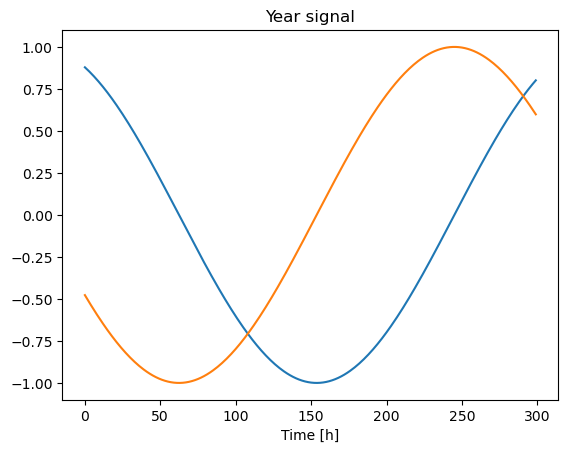

Epoch 1/17
462/462 - 1s - loss: 0.8202 - val_loss: 0.4233 - 1s/epoch - 3ms/step
Epoch 2/17
462/462 - 1s - loss: 0.7159 - val_loss: 0.3511 - 600ms/epoch - 1ms/step
Epoch 3/17
462/462 - 1s - loss: 0.6753 - val_loss: 0.3329 - 584ms/epoch - 1ms/step
Epoch 4/17
462/462 - 1s - loss: 0.6548 - val_loss: 0.3274 - 591ms/epoch - 1ms/step
Epoch 5/17
462/462 - 1s - loss: 0.6298 - val_loss: 0.3266 - 579ms/epoch - 1ms/step
Epoch 6/17
462/462 - 1s - loss: 0.6099 - val_loss: 0.3161 - 576ms/epoch - 1ms/step
Epoch 7/17
462/462 - 1s - loss: 0.5960 - val_loss: 0.3129 - 576ms/epoch - 1ms/step
Epoch 8/17
462/462 - 1s - loss: 0.5836 - val_loss: 0.3103 - 578ms/epoch - 1ms/step
Epoch 9/17
462/462 - 1s - loss: 0.5717 - val_loss: 0.3049 - 580ms/epoch - 1ms/step
Epoch 10/17
462/462 - 1s - loss: 0.5591 - val_loss: 0.2992 - 577ms/epoch - 1ms/step
Epoch 11/17
462/462 - 1s - loss: 0.5453 - val_loss: 0.3215 - 575ms/epoch - 1ms/step
Epoch 12/17
462/462 - 1s - loss: 0.5325 - val_loss: 0.3027 - 582ms/epoch - 1ms/step
Epoc

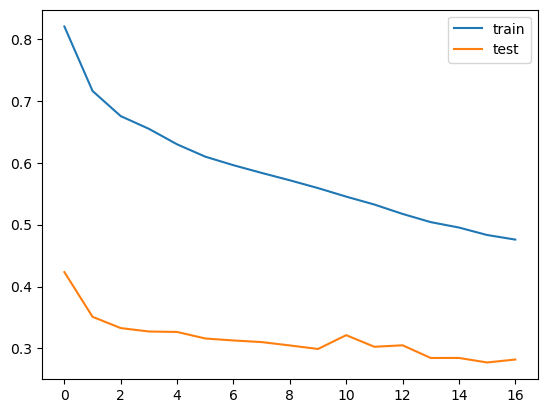

12/12 [==============================] - 0s 890us/step


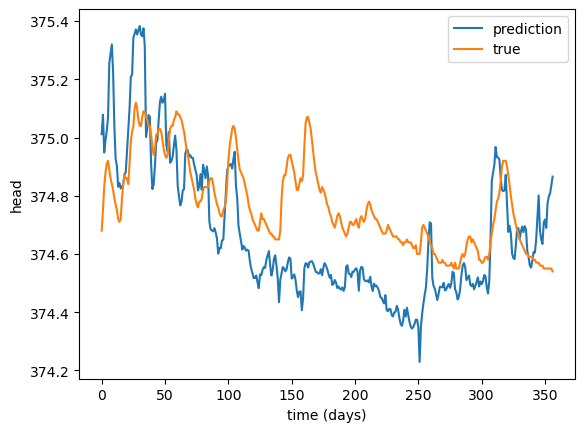

In [37]:
# read and preprocess data
df = read_data(target_path, feature_path)
lstm_ft_eng = engineer_features(df)
lstm_ft_eng.year_signal()
df = lstm_ft_eng.df

# remove highly correlated features
df = df.drop(columns = ['tn', 'tx', 'et'])

# create train-val-test data
train_X, train_y, val_X, val_y, test_X, test_y, scale_method = preprocessing_pipeline(df, 
                                                                                      '2015',
                                                                                      '2016', 
                                                                                      10, 
                                                                                      Standardize, 
                                                                                      'head')

# fit model:
lstm_model = get_model(50,1)

history = lstm_model.fit(train_X, 
                    train_y, 
                    epochs=17, 
                    batch_size=10, 
                    validation_data=(val_X, val_y), 
                    verbose=2, 
                    shuffle=False)

plot_training_history(history)

# evaluate model on test set:
y_pred = lstm_model.predict(test_X)
y_pred = scale_method.reverse_scale_target(y_pred)
test_y = scale_method.reverse_scale_target(test_y)
final_score = mean_squared_error(y_pred, test_y)

# visualize results on training, validation and test:
visualize_prediction(y_pred, test_y)



In [38]:
final_score

0.0418637216790341

12/12 [==============================] - 0s 785us/step


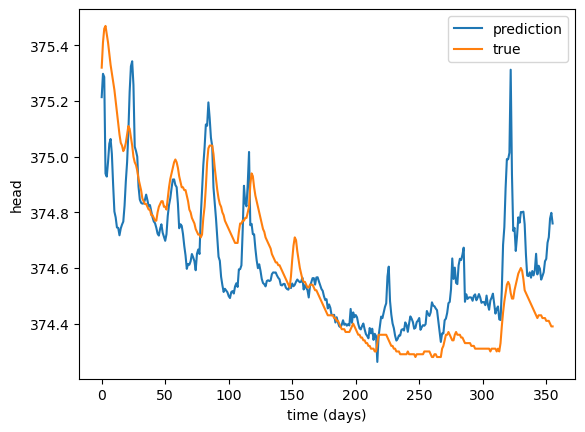

In [39]:
# evaluate model on validation set:
y_pred = lstm_model.predict(val_X)
y_pred = scale_method.reverse_scale_target(y_pred)
val_y = scale_method.reverse_scale_target(val_y)
final_score = mean_squared_error(y_pred, val_y)

# visualize results on training, validation and test:
visualize_prediction(y_pred, val_y)

In [35]:
final_score

0.03095241467410661